In [1]:
import numpy as np
from scipy import stats
import re
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../")
from common import data_utils as data_utils

In [11]:
folder = "raw/"

In [12]:
def read_cisc(file, lines):
    with open(str(folder + file), 'r', encoding="ascii", errors="backslashreplace") as f:
        for line in f:
            if re.findall(r'GET', line):
                aux = line.split('GET http://localhost:8080', 1)
                aux = aux[1].split(' HTTP/1.1\n',1)
                lines.append(aux[0])
            elif re.findall(r'POST', line):
                aux = line.split('POST http://localhost:8080', 1)
                aux= aux[1].split(' HTTP/1.1\n',1)
                aux = aux[0].rstrip()
                lines.append(aux)

In [13]:
def read_goodbad(file, lines):
    with open(str(folder + file), 'r', encoding="ascii", errors="backslashreplace") as f:
        samples = list(f)
        lines.extend(samples)


In [14]:
#Esta funcion toma un dataset y se queda solo con las URIs (recursos y parametros)
def read_kdd(file):
    by_class = {}
    last_class_read = ""
    with open(str(folder + file), 'r', encoding="ascii", errors="backslashreplace") as f:
        for line in f:     
            if re.findall(r'class: ', line):
                aux = line.split("class: ", 1)
                last_class_read = aux[1].replace('\n','')
            elif re.findall('^(?:GET|POST|PUT|DELETE)', line):
                aux = line.split(' ', 1)
                aux = re.compile("HTTP\/[0-9].[0-9]").split(aux[1])
                aux = aux[0].rstrip()
                list = by_class.get(last_class_read, [])
                list.append(aux)
                by_class[last_class_read] = list
    return by_class

In [15]:
def ints_to_word(ints):
    word = ''
    for i in ints:
        word += chr(i)
    return word

In [16]:
def word_to_ints(word):
    word_ints = []
    for char in word:
        word_ints.append(ord(char) + 1)
    return word_ints + [257]

In [17]:
def encode(lines):
    result = []
    for query in lines:
        query_ints = word_to_ints(query)
        result.append(query_ints)
    return result

In [18]:
kdd_by_class_train = read_kdd("xml_train.txt")
kdd_by_class_test = read_kdd("xml_test.txt")

## NORMAL GENERATION

In [19]:
good_lines = []
read_cisc("csic_2010_normalTrafficTraining.txt", good_lines)
print(len(good_lines))
read_cisc("csic_2010_normalTrafficTest.txt", good_lines)
print(len(good_lines))
read_goodbad("goodqueries.txt", good_lines)
print(len(good_lines))
good_lines.extend(kdd_by_class_train['Valid']) 
print(len(good_lines))
good_lines.extend(kdd_by_class_test['Valid']) 
print(len(good_lines))

36000
72000
1366531
1391035
1401537


In [23]:
data_utils.write_file(encode(good_lines), "normal.txt", split_token=' ', encoding='utf-8', errors='strict')

## ABNORMAL GENERATION

In [24]:
bad_lines = []
read_cisc("csic_2010_anomalousTrafficTest.txt", bad_lines)
print(len(bad_lines))
read_goodbad("badqueries.txt", bad_lines)
print(len(bad_lines))
bad_lines.extend(kdd_by_class_test['XPathInjection']) 
bad_lines.extend(kdd_by_class_test['OsCommanding']) 
bad_lines.extend(kdd_by_class_test['LdapInjection']) 
bad_lines.extend(kdd_by_class_test['SSI']) 
bad_lines.extend(kdd_by_class_test['PathTransversal']) 
bad_lines.extend(kdd_by_class_test['SqlInjection']) 
bad_lines.extend(kdd_by_class_test['XSS']) 
print(len(bad_lines))


24668
72794
87904


In [25]:
data_utils.write_file(encode(bad_lines), "abnormal.txt", split_token=' ', encoding='utf-8', errors='strict')

## To Numbers and Save

In [26]:
lens = [len(s) for s in encode(good_lines)]

In [27]:
print(stats.mode(lens), np.median(lens), np.mean(lens), min(lens), max(lens))

ModeResult(mode=array([10]), count=array([187763])) 16.0 24.241907277510332 8 547


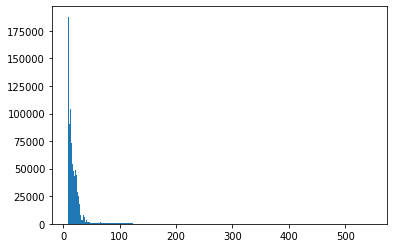

In [28]:
plt.hist(lens, bins=np.arange(min(lens), max(lens)+1), align='left')
plt.show()